In [29]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

import statsmodels.formula.api as smf

import requests as re

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split

sns.set_context('poster')
sns.set_style('whitegrid')

In [83]:
df = pd.read_json('./rawData/cleaned.json')
df.columns

Index(['Balcony', 'Cats_Allowed', 'Common_Outdoor_Space', 'Dining_Room',
       'Dishwasher', 'Dogs_Allowed', 'Doorman', 'Elevator', 'Exclusive',
       'Fitness_Center', 'Garden_Patio', 'Hardwood_Floors',
       'High_Speed_Internet', 'Laundry_in_Unit', 'Loft', 'New_Construction',
       'No_Fee', 'Outdoor_Space', 'Pre_War', 'Roof_Deck', 'Swimming_Pool',
       'Terrace', 'Wheelchair_Access', 'bathrooms', 'bedrooms', 'building_id',
       'created', 'description', 'display_address', 'features', 'interestVal',
       'interest_level', 'latitude', 'laundry_in_building', 'listing_id',
       'longitude', 'manager_id', 'price', 'street_address'],
      dtype='object')

Things to think about grouping
1. cats allowed / dogs allowed
2. doorman / exclusive
3. balcony / common outdoor space / garden/patio / roof deck / terrace
4. fitness center / swimming pool
5. 

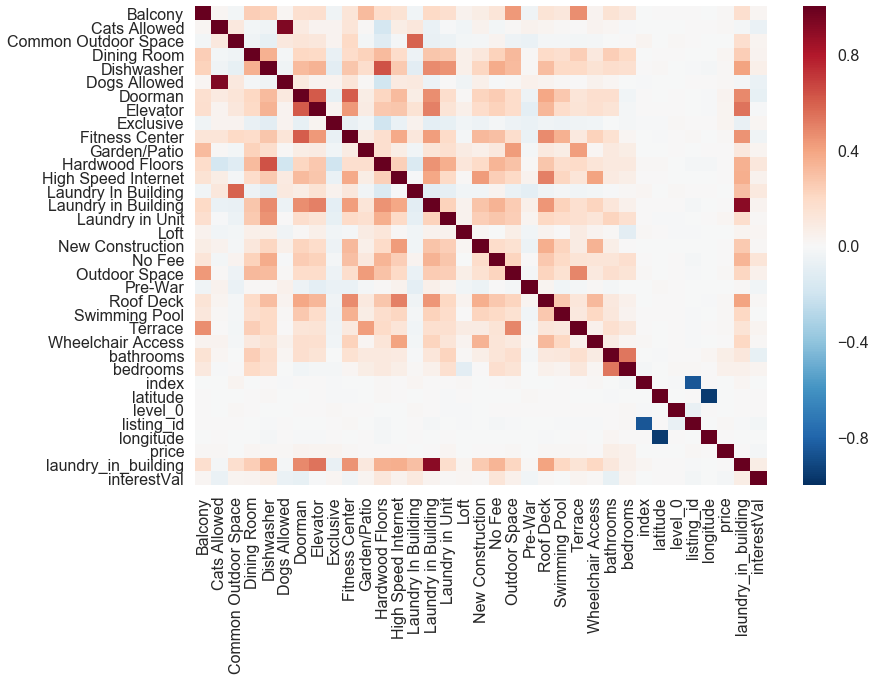

In [35]:
# Correlation Matrix of Data
sns.heatmap(df.corr())

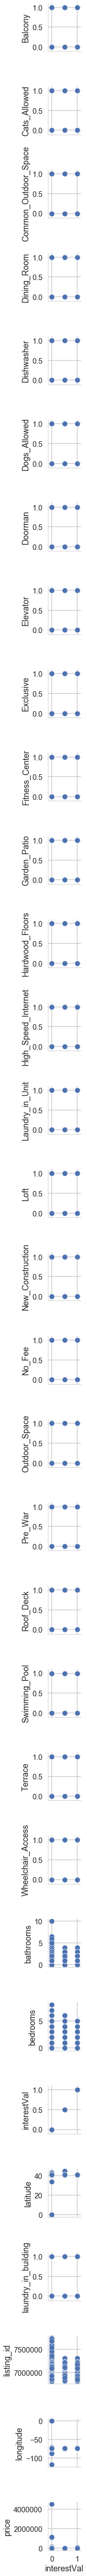

In [67]:
# See if we can get spread of interest level by different predictors
cols = df.select_dtypes(include=['float64', 'int64']).columns
sns.pairplot(df, x_vars=['interestVal'], y_vars=cols)
plt.savefig('interestLevelPairwise.png')

In [68]:
# Create interaction term for cats and dogs allowed
df['pets_allowed'] = df['Cats_Allowed'] * df['Dogs_Allowed']

In [69]:
# Create interaction term for doorman/exclusive
df['door_excl'] = df['Doorman'] * df['Exclusive']

In [70]:
# Create interaction term for fitness oriented
df['fitness_oriented'] = df['Fitness_Center'] * df['Swimming_Pool']

In [71]:
# Create transformed term that creates a score for outdoor spaces
df['outdoor_score'] = (df['Outdoor_Space'] + df['Balcony'] + df['Common_Outdoor_Space'] + df['Garden_Patio'] + df['Roof_Deck'] + df['Terrace']) / 6

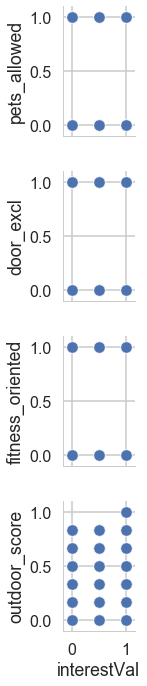

In [72]:
# Interest level vs. new interaction terms
sns.pairplot(df, x_vars=['interestVal'], y_vars=['pets_allowed', 'door_excl', 'fitness_oriented', 'outdoor_score'])

Only high interest listings have all 6 outdoor features.  So if a listing does not have a balcony, common outdoor space, garden/patio, roof deck, or terrace, then we know it is not high interest.

In [73]:
# ADA compatible interaction term
df['ada'] = df['Elevator'] * df['Wheelchair_Access']

In [75]:
# Luxury Score Term
df['lux_score'] = (df['Exclusive'] + df['Doorman'] + df['Outdoor_Space'] + df['New_Construction'] + df['Roof_Deck'] + df['Fitness_Center'] + df['Swimming_Pool'] + df['Elevator'] + df['Laundry_in_Unit'] + df['Hardwood_Floors']) / 10

In [76]:
def count_features(feats):
    return len(feats)

In [77]:
# Number of Features per Listing
df['num_features'] = df['features'].apply(lambda x: count_features(x))

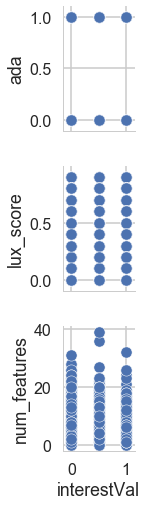

In [78]:
# Interest level vs. new interaction terms
sns.pairplot(df, x_vars=['interestVal'], y_vars=['ada', 'lux_score', 'num_features'])

It is interesting that a higher number of features doesn't seem to indicate more interest.  The highest number of features indicate medium amount of interest.

In [84]:
# Split into a training and a test set from training data
X_tr, X_test, Y_tr, Y_test = train_test_split(reduced_df, df['interestVal'], test_size=0.3, random_state=42)
X_tr.columns

Index(['Balcony', 'Cats_Allowed', 'Common_Outdoor_Space', 'Dining_Room',
       'Dishwasher', 'Dogs_Allowed', 'Doorman', 'Elevator', 'Exclusive',
       'Fitness_Center', 'Garden_Patio', 'Hardwood_Floors',
       'High_Speed_Internet', 'Laundry_In_Unit', 'Loft', 'New_Construction',
       'No_Fee', 'Outdoor_Space', 'Pre_War', 'Roof_Deck', 'Swimming_Pool',
       'Terrace', 'Wheelchair_Access', 'bathrooms', 'bedrooms', 'latitude',
       'listing_id', 'longitude', 'price', 'laundry_in_building',
       'interestVal', 'pets_allowed', 'door_excl', 'fitness_oriented',
       'outdoor_score', 'ada', 'lux_score', 'num_features'],
      dtype='object')

In [82]:
linReg = X_tr.select_dtypes(exclude=['object'])
equation = ('+').join(linReg.drop(['listing_id','interestVal'], axis=1).columns)
model = smf.ols('interestVal~'+equation, data=X_tr).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            interestVal   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     60.43
Date:                Mon, 20 Nov 2017   Prob (F-statistic):               0.00
Time:                        13:52:16   Log-Likelihood:                -6551.7
No. Observations:               29342   AIC:                         1.317e+04
Df Residuals:                   29307   BIC:                         1.346e+04
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.1409      0.101      1.395      0.163      -0.057       0.339
Balcony                  0.0052      0.009      0.589      0.556      -0.012       0.022
Cats_Allowed             0.0321      0.010      3.068      0.002       0.012       0.053
Common_Outdoor_Space     0.1008      0.012      8.561      0.000       0.078       0.124
Dining_Room              0.0088      0.007      1.306      0.192      -0.004       0.022
Dishwasher              -0.0065      0.005     -1.217      0.224      -0.017       0.004
Dogs_Allowed             0.1446      0.061      2.383      0.017       0.026       0.264
Doorman                 -0.0706      0.005    -13.026      0.000      -0.081      -0.060
Elevator                -0.0060      0.005     -1.171      0.242      -0.016       0.004
Exclusive                0.0674      0.010      6.700      0.000       0.048       0.087
Fitness_Center          -0.0386      0.006     -6.524      0.000      -0.050      -0.027
Garden_Patio             0.0062      0.011      0.592      0.554      -0.014       0.027
Hardwood_Floors          0.0574      0.005     11.466      0.000       0.048       0.067
High_Speed_Internet      0.0461      0.008      5.674      0.000       0.030       0.062
Laundry_In_Unit         -0.0183      0.006     -3.296      0.001      -0.029      -0.007
Loft                     0.0134      0.009      1.478      0.139      -0.004       0.031
New_Construction        -0.0068      0.009     -0.723      0.470      -0.025       0.012
No_Fee                   0.0736      0.004     16.432      0.000       0.065       0.082
Outdoor_Space            0.0207      0.007      2.806      0.005       0.006       0.035
Pre_War                 -0.0364      0.005     -7.683      0.000      -0.046      -0.027
Roof_Deck               -0.0116      0.007     -1.754      0.079      -0.025       0.001
Swimming_Pool           -0.0042      0.025     -0.170      0.865      -0.052       0.044
Terrace                  0.0007      0.010      0.069      0.945      -0.020       0.021
Wheelchair_Access        0.1295      0.091      1.417      0.156      -0.050       0.309
bathrooms               -0.0696      0.004    -15.765      0.000      -0.078      -0.061
bedrooms                 0.0157      0.002      7.943      0.000       0.012       0.020
latitude                 0.0062      0.009      0.694      0.488      -0.011       0.024
longitude                0.0021      0.005      0.431      0.666      -0.007       0.011
price                -1.847e-06   2.55e-07     -7.233      0.000   -2.35e-06   -1.35e-06
laundry_in_building      0.0500      0.005      9.709      0.000       0.040       0.060
pets_allowed            -0.1953      0.062     -3.173      0.002      -0.316      -0.075
door_excl               -0.0732      0.020     -3.652    